In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

### Named Entity Recognition

Our task here is to predict the type of entity each word is in a sentence. Same word can have different entities in different sentences, so it's important to take sentences as sequence of words as input and not individual words independently. So, it's sequential modelling.

It's important to note that the case is important in extracting entitites, so we should not lowercase every word and should treat lowercase and uppercase/titlecase of same word differently.

#### Dataset Link: [Kaggle](https://www.kaggle.com/datasets/abhinavwalia95/entity-annotated-corpus)

### Steps:

1. **Data Preprocessing:**
    1. Convert words into sentences
    2. Map words/tags into unique IDs
    3. Pad sentences to maximum sequence length using [PAD] token
    4. Add Special Tokens:
        1. [CLS]: Classification token to summarize sentence placed at beginning of sentence
        2. [SEP]: Separator token to mark end of sentence, placed at end of sentence. Short sentences are padded after [SEP] token.
        
2. **Convert word ids to embeddings:**
    1. Use one-hot encoding:
        1. Increase data volume and sparsity
        2. Considers words to independent of each other
    2. Use embeddings of pre-defined length:
        1. Learn an embedding layer
        2. Pre-trained word embeddings from BERT, GLoVe, Word2Vec
        3. Special tokens like [CLS], [SEP], [PAD] etc. have fixed embeddings (positional) from trained BERT models. However, these do not contain any information themselves.

3. **Train sequence model:**
    1. RNN/LSTM/GRU layers
    2. Classification problem:
        1. Softmax as final activation
        2. Number of entities as unique classes

4. **Inference:**
    1. Prediction 
    2. Evaluation on metrics like Precision, Recall

In [2]:
data = pd.read_csv('ner_dataset/ner_dataset.csv', encoding='Latin-1')
print('Shape:', data.shape)

Shape: (1048575, 4)


In [3]:
sample_size = 20000
data = data[:sample_size]
data = data.ffill(axis=0)
data.head(2)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O


In [4]:
data.drop(columns = 'POS', inplace=True)
num_words = data['Word'].nunique()
num_entities = data['Tag'].nunique()

num_words, num_entities

(4328, 17)

In [5]:
# adding special tokens
token2int = {}
token2int['PAD'] = 0
token2int['CLS'] = 1
token2int['SEP'] = 2
token2int.update(dict(zip(data['Word'].unique(), range(3, num_words+3))))

int2token = {v:k for k, v in token2int.items()}

tag2int = dict(zip(data['Tag'].unique(), range(num_entities)))
int2tag = {v:k for k, v in tag2int.items()}

In [6]:
data['Word'].replace(token2int, inplace=True)
data['Tag'].replace(tag2int, inplace=True)

In [7]:
df = data.groupby(['Sentence #'])[['Word', 'Tag']].agg(lambda x: list(x)).reset_index()
print('Shape:', df.shape)
df.head(2)

Shape: (903, 3)


,Sentence #,Word,Tag
0,Sentence: 1,"[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,Sentence: 10,"[127, 128, 129, 130, 131, 10, 132, 133, 10, 13...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
df['sent_length'] = df['Word'].apply(lambda x: len(x))
max_length = np.max(df['sent_length'].values)
max_tag_length = np.max(df['Tag'].apply(lambda x: len(x)).values)
print('Maximum Sentence Length:', max_length)
assert max_length == max_tag_length

Maximum Sentence Length: 62


In [9]:
# adding BOS, EOS tokens
df['Word'] = df['Word'].apply(lambda x: [token2int['CLS']] + x + [token2int['SEP']])

# adding other tag for BOS, EOS tokens
df['Tag'] = df['Tag'].apply(lambda x: [tag2int['O']] + x + [tag2int['O']])

# adding padding tokens
df['Padding'] = df['sent_length'].apply(lambda x: [0] * (max_length - x))
df['Word'] = df['Word'] + df['Padding']
df['Tag'] = df['Tag'] + df['Padding']

In [10]:
# 3 extra tokens for PAD, CLS, SEP
num_tokens = num_words + 3

X = df['Word'].values
X = np.array(list(map(lambda x: np.array(x), X)))
X = keras.utils.to_categorical(X, num_classes=num_tokens)

y = df['Tag'].values
y = np.array(list(map(lambda x: np.array(x), y)))

X.shape, y.shape

((903, 64, 4331), (903, 64))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((722, 64, 4331), (181, 64, 4331), (722, 64), (181, 64))

### Important Points:

1. Since sequential data is temporal in nature, it has a time-associated component which is reflected by sequence length in its shape.
2. **Shape of data:** [batch_size, time_steps, features]. We keep <code>return_sequences = True</code> so that the model outputs a vector at each timestep and not just at the end of sequence, to maintain the shape.
3. Note that the sentences themselves are not temporally connected here, it's the words within a sentence that form a sequence. Hence: 
    1. We can shuffle sentences but not words
    2. LSTM layers are **stateless**
4. Since we already have a dimension for timesteps, applying a TimeDistributed wrapper over Dense layer is same as not applying it.

In [12]:
_, num_timesteps, num_features = X.shape
num_timesteps, num_features

(64, 4331)

In [13]:
model = Sequential()
model.add(LSTM(100, activation='tanh', return_sequences=True, stateful=False))
model.add(Dropout(0.25))
model.add(LSTM(50, activation='tanh', return_sequences=True, stateful=False))
model.add(Dropout(0.5))
model.add(Dense(num_entities, activation='softmax'))

model.build(input_shape=(None, num_timesteps, num_features))
model.summary()

2022-03-29 14:16:54.352851: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64, 100)           1772800   
                                                                 
 dropout (Dropout)           (None, 64, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64, 50)            30200     
                                                                 
 dropout_1 (Dropout)         (None, 64, 50)            0         
                                                                 
 dense (Dense)               (None, 64, 17)            867       
                                                                 
Total params: 1,803,867
Trainable params: 1,803,867
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam())
estop = EarlyStopping(patience=5)

history = model.fit(X_train, y_train, epochs = 50, shuffle = True, 
                    batch_size = 16, validation_split = 0.2, verbose=1, callbacks=[estop])

Epoch 1/50
37/37 [==============================] - 13s 275ms/step - loss: 1.1842 - val_loss: 0.4582
Epoch 2/50
37/37 [==============================] - 9s 232ms/step - loss: 0.4130 - val_loss: 0.4071
Epoch 3/50
37/37 [==============================] - 9s 240ms/step - loss: 0.3900 - val_loss: 0.3906
Epoch 4/50
37/37 [==============================] - 9s 239ms/step - loss: 0.3746 - val_loss: 0.3791
Epoch 5/50
37/37 [==============================] - 9s 236ms/step - loss: 0.3605 - val_loss: 0.3647
Epoch 6/50
37/37 [==============================] - 9s 239ms/step - loss: 0.3478 - val_loss: 0.3457
Epoch 7/50
37/37 [==============================] - 10s 260ms/step - loss: 0.3290 - val_loss: 0.3225
Epoch 8/50
37/37 [==============================] - 9s 243ms/step - loss: 0.3057 - val_loss: 0.3097
Epoch 9/50
37/37 [==============================] - 8s 229ms/step - loss: 0.2845 - val_loss: 0.2896
Epoch 10/50
37/37 [==============================] - 8s 226ms/step - loss: 0.2672 - val_loss: 0.27

In [15]:
def plotting(train_loss, val_loss):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(train_loss, label = 'Train Loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(val_loss, label = 'Validation Loss')
    plt.legend()
    plt.show()

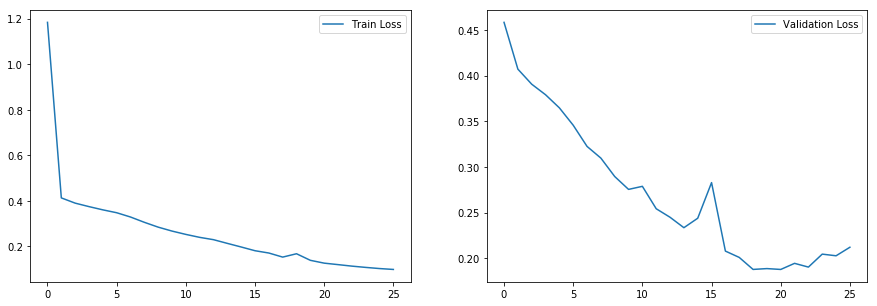

In [16]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plotting(train_loss, val_loss)

In [62]:
y_pred = np.argmax(model.predict(X_test), axis=2)
y_pred = np.array(list(map(lambda y: list(map(lambda x: int2tag[x], y)), y_pred)))

In [70]:
def test_example(idx, y_pred):
    sent = np.argmax(X_test[idx], axis=1)
    sent = np.array(list(map(lambda x: int2token[x], sent)))
    bos_id = np.where(sent=='CLS')[0][0]
    eos_id = np.where(sent=='SEP')[0][0]

    sent = sent[bos_id+1:eos_id]
    pred_entities = y_pred[idx][bos_id+1:eos_id]
    named_entities = np.where(pred_entities!='O')[0]

    print('Named Entities: ', sent[named_entities])
    print('Prediction: ', pred_entities[named_entities])
    return 

In [71]:
idx = 0
test_example(idx, y_pred)

Named Entities:  ['Palestinian']
Prediction:  ['B-gpe']


In [78]:
idx = 34
test_example(idx, y_pred)

Named Entities:  ['Egyptian' 'Muslim' 'Brotherhood']
Prediction:  ['B-gpe' 'B-geo' 'B-geo']
